# IIC2115 - Programación como herramienta para la ingeniería

## Ejercicio 3 - Análisis de Redes Viales

### Importando Librerías

In [1]:
# Importar librerías necesarias
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# También es útil configurar la visualización
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 12})

## Cargando Datos

In [2]:
# Cargar datos de accidentes, que son geoespaciales (geojson)
accidentes = gpd.read_file('Data/Accidentes/Atropellos_2020.geojson')
bicicletas = gpd.read_file('Data/Accidentes/Bicicletas_2019.geojson')
motocicletas = gpd.read_file('Data/Accidentes/Motocicletas_2019.geojson')
puntos_criticos = gpd.read_file('Data/Accidentes/Puntos_criticos_2019.geojson')

# Cargar datos de seguridad, que a diferencia de los anteriores, no son geoespaciales (csv)
seguridad = pd.read_csv('Data/Seguridad/seguridad_santiago.csv')

In [3]:
# Cargar datos de comunas
comunas = gpd.read_file('Data/Comunas/comunas.shp')
comunas.to_crs("EPSG:4326", inplace=True) # Inplace para modificar el DataFrame original

In [4]:
comunas.columns

Index(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry'],
      dtype='object')

## Ejercicio 1: Viaje desde Sala A1 hasta Cerro Chena

In [5]:
# Coordenadas de origen y destino
sala_A1 = (-33.50026366987983, -70.6127608118863)  # Sala A1 Campus San Joaquín, que será el origen.
cerro_chena = (-33.593891, -70.742777)  # Cima del Cerro Chena, que será el destino.

In [6]:
# Descargamos la red peatonal para el área de Santiago
G_peatonal = ox.graph_from_place(['Santiago, Chile', 'San Bernardo, Chile'], network_type='walk') # Le ponemos network_type='walk' para que sea peatonal.

In [7]:
# Buscamos los nodos más cercanos en la red peatonal
nodo_origen = ox.distance.nearest_nodes(G_peatonal, sala_A1[1], sala_A1[0])
nodo_destino = ox.distance.nearest_nodes(G_peatonal, cerro_chena[1], cerro_chena[0])

print(f"Nodo origen: {nodo_origen}")
print(f"Nodo destino: {nodo_destino}")

Nodo origen: 471557074
Nodo destino: 8127395413


In [8]:
# Calculamos la ruta más corta
ruta = nx.shortest_path(G_peatonal, nodo_origen, nodo_destino, weight='length')
distancia_total = nx.shortest_path_length(G_peatonal, nodo_origen, nodo_destino, weight='length')
    
print(f"Distancia total: {round(distancia_total, 2)} metros")
print(f"Tiempo estimado caminando (3 km/h): {round((distancia_total/1000)/3*60, 2)} minutos")

Distancia total: 12291.21 metros
Tiempo estimado caminando (3 km/h): 245.82 minutos


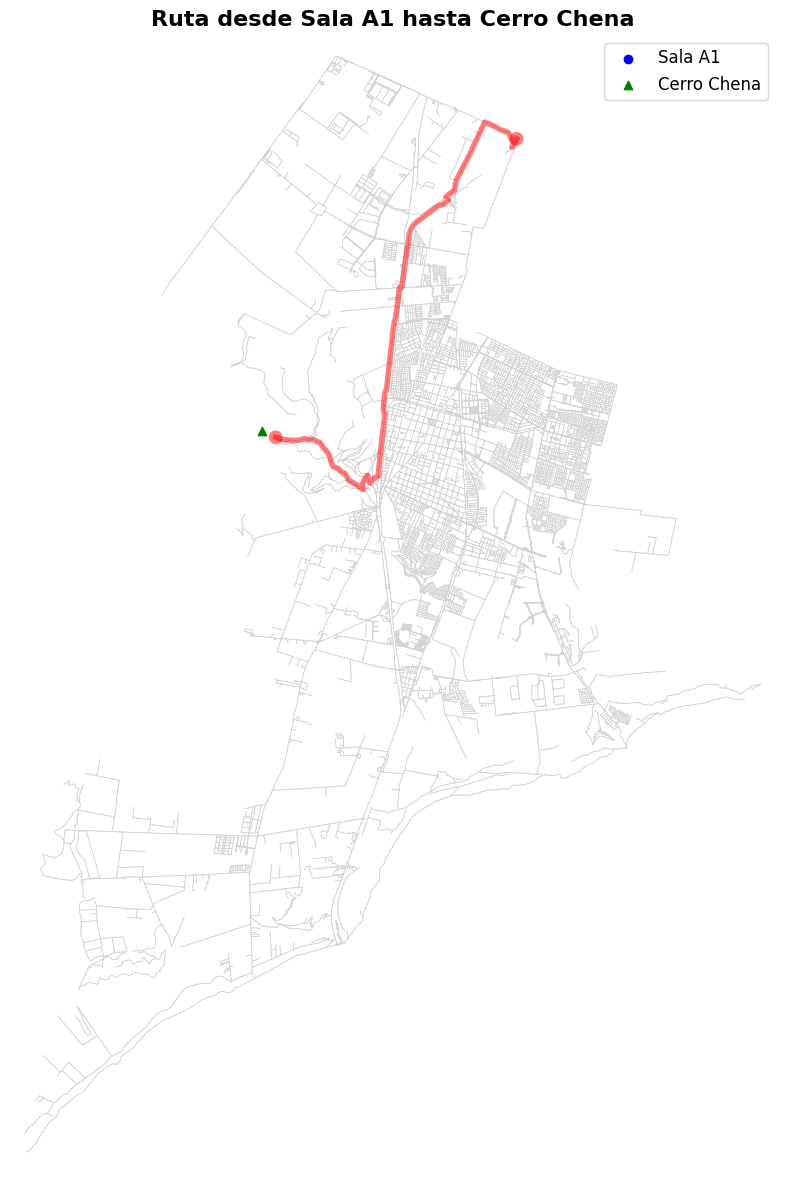

Distancia total: 12291.21 metros (12.29 km)
Tiempo estimado: 245.82 minutos
Velocidad promedio: 3 km/h (caminando)


In [9]:
# Visualización de la ruta
    
# Creamos la figura
fig, ax = plt.subplots(figsize=(15, 12))

# Graficamos la red peatonal
ox.plot_graph(G_peatonal, ax=ax, node_size=0, edge_color='lightgray', 
                edge_linewidth=0.5, bgcolor='white', show=False, close=False)

# Graficamos la ruta
ox.plot_graph_route(G_peatonal, ruta, route_color='red', route_linewidth=4, 
                    ax=ax, show=False, close=False, label='Ruta óptima')

# Marcamos el origen y el destino con un color y simbolo distinto en el mapa. 
ax.scatter(sala_A1[1], sala_A1[0], c='blue', marker='o', 
            label='Sala A1')
ax.scatter(cerro_chena[1], cerro_chena[0], c='green', marker='^', 
            label='Cerro Chena')

# Configuramos el gráfico
ax.set_title('Ruta desde Sala A1 hasta Cerro Chena', fontsize=16, fontweight='bold')
ax.legend(fontsize=12) # Acá ponemos el tamaño de la fuente de la leyenda
ax.set_xlabel('Longitud', fontsize=12) # Acá ponemos el tamaño del eje x en la imagen
ax.set_ylabel('Latitud', fontsize=12) # Acá ponemos el tamaño del eje y en la imagen

plt.tight_layout()
plt.show()

print(f"Distancia total: {distancia_total:.2f} metros ({distancia_total/1000:.2f} km)")
print(f"Tiempo estimado: {(distancia_total/1000)/3*60:.2f} minutos")
print(f"Velocidad promedio: 3 km/h (caminando)")


## Ejercicio 2: Análisis de Centralidad en Ñuñoa

In [10]:
# Descargamos la red vial de Ñuñoa
G_nunoa = ox.graph_from_place('Ñuñoa, Chile', network_type='drive')

print(f"Red vial de Ñuñoa: {G_nunoa.number_of_nodes()} nodos, {G_nunoa.number_of_edges()} aristas")

Red vial de Ñuñoa: 2736 nodos, 6080 aristas


In [11]:
# Calculamos métricas de centralidad
centralidad_betweenness = nx.betweenness_centrality(G_nunoa, weight='length')
centralidad_closeness = nx.closeness_centrality(G_nunoa, distance='length')

# Creamos un DataFrame para el análisis de las métricas.
centralidad_df = pd.DataFrame({
    'betweenness': centralidad_betweenness,
    'closeness': centralidad_closeness
})

# Calculamos el percentil 90 con el metodo quantile
percentil_90_betweenness = centralidad_df['betweenness'].quantile(0.9)
percentil_90_closeness = centralidad_df['closeness'].quantile(0.9)

# Identificamos los nodos en el percentil 90
nodos_criticos_betweenness = centralidad_df[centralidad_df['betweenness'] >= percentil_90_betweenness].index.tolist() # Aca obtenemos los nodos que estan en el percentil 90 de
                                                                                                                        # la métrica betweenness
nodos_criticos_closeness = centralidad_df[centralidad_df['closeness'] >= percentil_90_closeness].index.tolist() # Aca obtenemos los nodos que estan en el percentil 90 de 
                                                                                                                # la métrica closeness

print(f"Percentil 90 betweenness: {round(percentil_90_betweenness, 3)}")
print(f"Percentil 90 closeness: {round(percentil_90_closeness, 3)}")
print(f"Nodos críticos por betweenness: {len(nodos_criticos_betweenness)}")
print(f"Nodos críticos por closeness: {len(nodos_criticos_closeness)}")

Percentil 90 betweenness: 0.038
Percentil 90 closeness: 0.0
Nodos críticos por betweenness: 274
Nodos críticos por closeness: 274


In [12]:
G_nunoa.nodes


NodeView((13877015, 13877020, 13877021, 13877130, 13877387, 13877389, 13877390, 13877394, 13877397, 13877399, 13877404, 13877414, 13877424, 13877427, 13877435, 13877451, 13877454, 13877459, 13877461, 13877462, 13877464, 13877465, 13877531, 13877532, 13877538, 13877547, 13877548, 13877549, 13877553, 13880364, 13882110, 13882111, 13882139, 13882144, 13882148, 13882149, 13882150, 13882163, 13882164, 13882167, 13882169, 14760650, 14760652, 14805060, 15073497, 15073504, 15073529, 15073530, 15073532, 15092684, 15092685, 15092686, 15172883, 15172884, 15172885, 15172886, 15172891, 15172892, 16967584, 16967585, 18321705, 18321706, 18321707, 18321708, 18321717, 18321720, 18321723, 130018538, 130018884, 130019048, 133768674, 133768692, 133768764, 133768799, 133768816, 133768831, 133768834, 133769115, 133769246, 133769267, 133769281, 133769284, 133769331, 133769392, 139427165, 139427184, 139427195, 139427232, 139427250, 139427266, 139427282, 139427297, 139427314, 139427319, 139427330, 139427344, 1

(<Figure size 1500x1200 with 1 Axes>, <Axes: >)

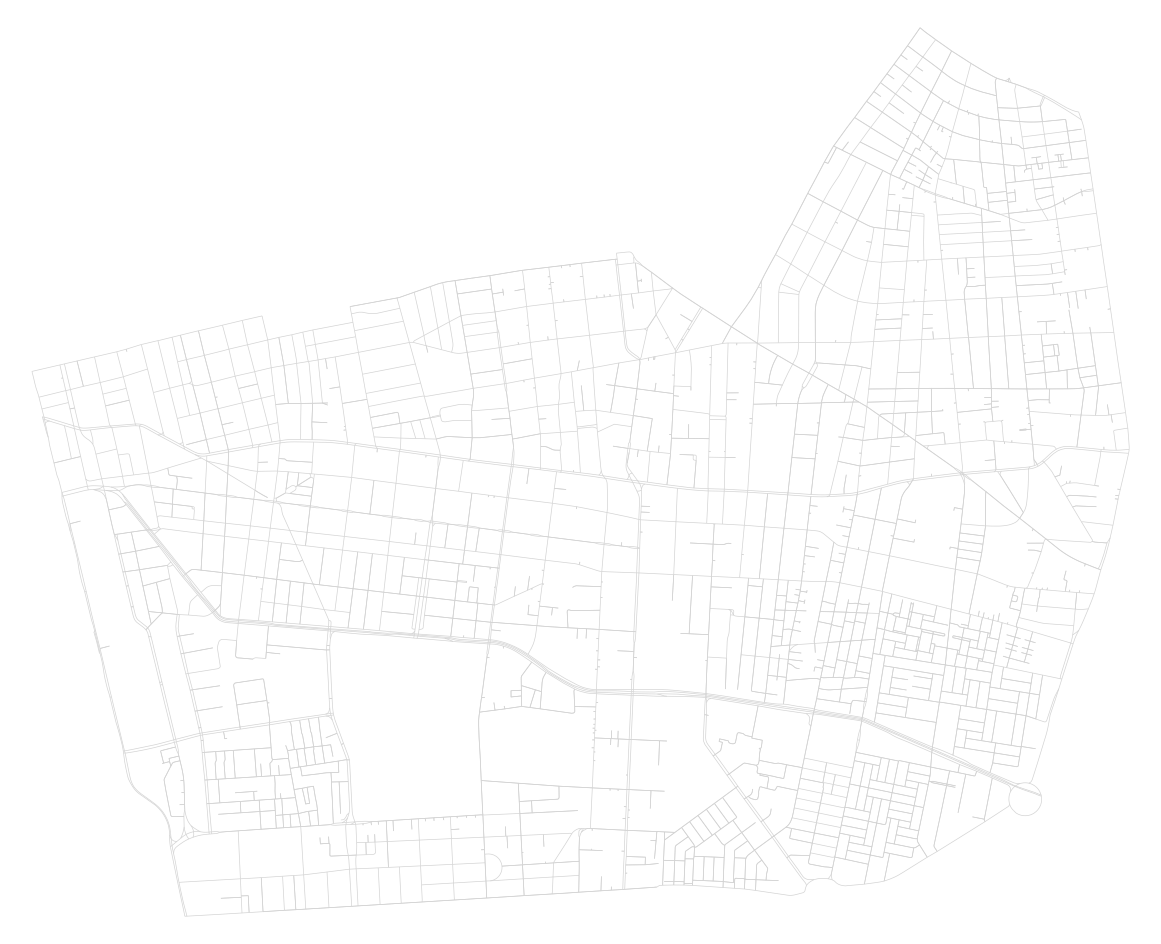

In [13]:
# Visualizamos los nodos críticos y puntos de accidentes, de las métricas betweenness y closeness.

fig, ax = plt.subplots(figsize=(15, 12))

# Graficamos la red vial en la figura ax
ox.plot_graph(G_nunoa, ax=ax, node_size=0, edge_color='lightgray', edge_linewidth=0.5, 
              bgcolor='white', show=False, close=False)


In [14]:
# Extraemos las coordenadas de los nodos críticos
nodos_criticos_coordenadas = []
for nodo in nodos_criticos_betweenness:
    if nodo in G_nunoa.nodes:
        x, y = G_nunoa.nodes[nodo]['x'], G_nunoa.nodes[nodo]['y']
        nodos_criticos_coordenadas.append((x, y))

nodos_closeness_coordenadas = []
for nodo in nodos_criticos_closeness:
    if nodo in G_nunoa.nodes:
        x, y = G_nunoa.nodes[nodo]['x'], G_nunoa.nodes[nodo]['y']
        nodos_closeness_coordenadas.append((x, y))

In [15]:
x_coordenadas, y_coordenadas = [], []
for coordenada in nodos_criticos_coordenadas:
    x_coordenadas.append(coordenada[0])
    y_coordenadas.append(coordenada[1])

# Con scatter lo que hacemos es que para cada lista de coordenadas, separemos las coordenadas x e y, y las graficamos en la figura ax.
ax.scatter(x_coordenadas, y_coordenadas, c='red', s=50, alpha=0.7, zorder=3,
        label=f'Nodos críticos (Betweenness) - {len(nodos_criticos_coordenadas)} nodos')

# Calculamos los nodos críticos por closeness 
x_coordenadas, y_coordenadas = [], []
for coordenada in nodos_closeness_coordenadas:
    x_coordenadas.append(coordenada[0])
    y_coordenadas.append(coordenada[1])

ax.scatter(x_coordenadas, y_coordenadas, c='blue', s=50, alpha=0.7, zorder=3,
           label=f'Nodos críticos (Closeness) - {len(nodos_closeness_coordenadas)} nodos')

In [16]:
puntos_criticos.head()

,FID,Ano,Codregion,Region,Comuna,Zona,Calle1,Calle2,Numero,lat,...,Cód_Calza,Calzada,Cód__Tipo,Tipo_Calza,Fallecidos,Graves,Menos_Grav,Leves,Accidentes,geometry
0,1,2019,13,REGION METROPOLITANA,SANTIAGO,URBANA,LIBER BERNARDO O`HIGGINS,MORANDE,NULL,-33.444637,...,3,BIDIRECCIONAL CON BANDEJON,2,ASFALTO,0,0,0,7,8,POINT (-70.65286 -33.44464)
1,2,2019,13,REGION METROPOLITANA,LO BARNECHEA,URBANA,LA DEHESA,RAUL LABBE,NULL,-33.364101,...,1,UNIDIRECCIONAL,2,ASFALTO,0,1,1,1,8,POINT (-70.51404 -33.36410)
2,3,2019,13,REGION METROPOLITANA,SAN MIGUEL,URBANA,GRAN AVDA JOSE MIGUEL CARRERA,VENTURA BLANCO VIEL,NULL,-33.496384,...,2,BIDIRECCIONAL,2,ASFALTO,0,0,0,1,5,POINT (-70.65280 -33.49638)
3,4,2019,13,REGION METROPOLITANA,INDEPENDENCIA,URBANA,STA MARIA,NULL,1204,-33.431538,...,1,UNIDIRECCIONAL,2,ASFALTO,0,0,1,2,7,POINT (-70.65271 -33.43153)
4,5,2019,13,REGION METROPOLITANA,LO BARNECHEA,URBANA,LAS CONDES,LA DEHESA,NULL,-33.370831,...,3,BIDIRECCIONAL CON BANDEJON,2,ASFALTO,0,0,0,1,5,POINT (-70.51144 -33.37083)


In [17]:
# Graficamos ahora los puntos críticos de accidentes
puntos_criticos.plot(ax=ax, color='orange', markersize=30, alpha=0.8, 
                        label=f'Puntos críticos de accidentes - {len(puntos_criticos)} puntos')

<Axes: >

<Figure size 1500x1000 with 0 Axes>

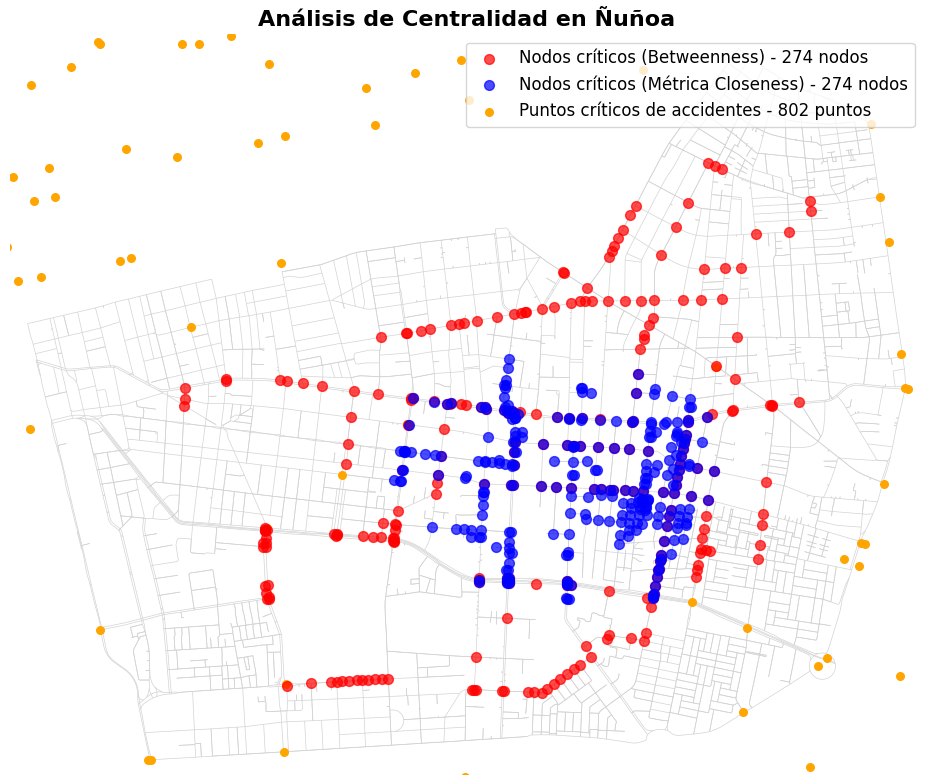

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

# Graficamos la red vial en la figura ax
ox.plot_graph(G_nunoa, ax=ax, node_size=0, edge_color='lightgray', edge_linewidth=0.5, 
              bgcolor='white',show=False, close=False) # Acá ponemos show=False y close=False para que no se muestre el gráfico automáticamente.

# Calculamos los nodos críticos por betweenness 
x_coordenadas, y_coordenadas = [], []
for coordenada in nodos_criticos_coordenadas:
    x_coordenadas.append(coordenada[0])
    y_coordenadas.append(coordenada[1])

ax.scatter(x_coordenadas, y_coordenadas, c='red', s=50, alpha=0.7,zorder=3,
        label=f'Nodos críticos (Betweenness) - {len(nodos_criticos_coordenadas)} nodos')

# Calculamos los nodos críticos por closeness 
x_coordenadas, y_coordenadas = [], []
for coordenada in nodos_closeness_coordenadas:
    x_coordenadas.append(coordenada[0])
    y_coordenadas.append(coordenada[1])

ax.scatter(x_coordenadas, y_coordenadas, c='blue',s=50, alpha=0.7,zorder=3,
           label=f'Nodos críticos (Métrica Closeness) - {len(nodos_closeness_coordenadas)} nodos') # s es el tamaño de los puntos, alpha la transparencia y zorder es el orden en que se dibujan los puntos.

# Graficamos ahora los puntos críticos de accidentes
puntos_criticos.plot(ax=ax, color='orange', markersize=30, 
                        label=f'Puntos críticos de accidentes - {len(puntos_criticos)} puntos')

# Realizamos las ultimas configuraciones y visualizamos el gráfico. 
ax.set_title('Análisis de Centralidad en Ñuñoa', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

plt.tight_layout()
plt.show()

In [19]:

print(f"Nodos críticos por betweenness: {len(nodos_criticos_betweenness)}")
print(f"Nodos críticos por closeness: {len(nodos_criticos_closeness)}")
print(f"Puntos críticos de accidentes: {len(puntos_criticos)}")

Nodos críticos por betweenness: 274
Nodos críticos por closeness: 274
Puntos críticos de accidentes: 802


## Ejercicio 3: Selección de Distritos y Optimización de Rutas

In [20]:
seguridad.head()

,seguridad,lat,lon
0,-0.120456,-33.323944,-70.512634
1,-0.103042,-33.323944,-70.512729
2,0.391172,-33.323944,-70.512987
3,0.300856,-33.323944,-70.513436
4,-0.946355,-33.323944,-70.513798


In [21]:
# Buscamos el punto, según la latitud y longitud con mayor inseguridad, que sería el valor más negativo de la columna "seguridad"
punto_inseguro = seguridad.loc[seguridad['seguridad'].idxmin()]
print(f"Punto con mayor inseguridad:")
print(f"Coordenadas: lat={round(punto_inseguro['lat'], 3)}, lon={round(punto_inseguro['lon'], 3)}")
print(f"Valor seguridad: {round(punto_inseguro['seguridad'], 3)}")

Punto con mayor inseguridad:
Coordenadas: lat=-33.462, lon=-70.7
Valor seguridad: -4.409


In [22]:
# Buscamos también el opuesto, es decir, el punto con mayor seguridad, que sería el valor más positivo de la columna "seguridad"
punto_seguro = seguridad.loc[seguridad['seguridad'].idxmax()]
print(f"Punto con mayor seguridad:")
print(f"Coordenadas: lat={round(punto_seguro['lat'], 3)}, lon={round(punto_seguro['lon'], 3)}")
print(f"Valor seguridad: {round(punto_seguro['seguridad'], 3)}")

Punto con mayor seguridad:
Coordenadas: lat=-33.613, lon=-70.503
Valor seguridad: 4.209


In [23]:
# El punto con la seguridad también es un factor relevante, por lo que lo buscamos también.
seguridad_media = seguridad['seguridad'].median()
punto_medio = seguridad.loc[(seguridad['seguridad'] - seguridad_media).abs().idxmin()]
print(f"Punto con seguridad promedio:")
print(f"Coordenadas: lat={round(punto_medio['lat'], 3)}, lon={round(punto_medio['lon'], 3)}")
print(f"Valor seguridad: {round(punto_medio['seguridad'], 3)}")

Punto con seguridad promedio:
Coordenadas: lat=-33.451, lon=-70.661
Valor seguridad: -0.007


In [24]:
# Por último, el punto con mayor variabilidad, es decir, el punto más alejado de la media.
punto_variabilidad = seguridad.loc[(seguridad['seguridad'] - seguridad['seguridad'].mean()).abs().idxmax()]
print(f"Punto con mayor variabilidad:")
print(f"Coordenadas: lat={round(punto_variabilidad['lat'], 3)}, lon={round(punto_variabilidad['lon'], 3)}")
print(f"Valor seguridad: {punto_variabilidad['seguridad']:.3f}")

Punto con mayor variabilidad:
Coordenadas: lat=-33.462, lon=-70.7
Valor seguridad: -4.409


In [25]:
distritos = gpd.read_file('Data/Distritos Censales/Distritos Censales RM.shp')
distritos.head()

,NOM_REG,COD_PROV,NOM_PROV,COD_COM,NOM_COM,NOM_DIS,CODIGO,E,D,C3,C2,ABC1,ADIMARK_T,Area,Densidad,1_UF_M2,geometry
0,Región Metropolitana De Santiago,131,Santiago,13101,Santiago,Huelén,1310101.0,28.0,397.0,1232.0,1390.0,365.0,3412.0,704315.75,48.44,31.09,"POLYGON ((346775.511 6299463.724, 346788.392 6..."
1,Región Metropolitana De Santiago,131,Santiago,13101,Santiago,Moneda,1310102.0,51.0,560.0,999.0,903.0,228.0,2741.0,1166659.89,23.49,21.10,"POLYGON ((345880.280 6299633.958, 345961.610 6..."
2,Región Metropolitana De Santiago,131,Santiago,13101,Santiago,Amunátegui,1310103.0,38.0,389.0,956.0,891.0,113.0,2387.0,509080.85,46.89,12.00,"POLYGON ((345546.017 6299748.840, 345650.511 6..."
3,Región Metropolitana De Santiago,131,Santiago,13101,Santiago,Brasil,1310104.0,52.0,657.0,1728.0,2202.0,423.0,5062.0,761738.52,66.45,10.25,"POLYGON ((344856.320 6298892.632, 345672.277 6..."
4,Región Metropolitana De Santiago,131,Santiago,13101,Santiago,Chacabuco,1310105.0,45.0,643.0,1092.0,974.0,145.0,2899.0,765782.74,37.86,11.87,"POLYGON ((343856.526 6298225.435, 344041.982 6..."


In [26]:
# Distritos con mayor densidad poblacional
distritos_por_densidad = distritos.nlargest(4, 'Densidad')[['NOM_COM', 'Densidad']]
for i, (index, fila) in enumerate(distritos_por_densidad.iterrows(), 1):
    print(f'{fila["NOM_COM"]}: {round(fila["Densidad"], 2)} hab/km²')

El Bosque: 73.24 hab/km²
La Florida: 70.72 hab/km²
Santiago: 66.45 hab/km²
Santiago: 63.52 hab/km²


In [27]:
# VALOR DEL SUELO 
distritos_por_suelo = distritos.nlargest(4, '1_UF_M2')[['NOM_COM', '1_UF_M2']]
for i, (index, fila) in enumerate(distritos_por_suelo.iterrows(), 1):
    print(f'{fila["NOM_COM"]}: {round(fila["1_UF_M2"], 2)} UF/m²')

Providencia: 41.13 UF/m²
Las Condes: 40.83 UF/m²
Vitacura: 31.83 UF/m²
Santiago: 31.09 UF/m²


In [28]:
# Dado que una comuna puede tener más de un distrito, usamos "dissolve" para aseguramos que haya un polígono por comuna

distritos = distritos.set_crs(32719)

comunas_geometria = (
    distritos[['NOM_COM', 'geometry']]
    .dissolve(by='NOM_COM', as_index=False)  # Hacemos esto porque una comuna puede tener más de un distrito, por lo tanto, aseguramos con esto que haya un polígono por comuna
    .rename(columns={'NOM_COM':'comuna'})
)

comunas_geometria.head()


,comuna,geometry
0,Alhue,"POLYGON ((320971.893 6224571.577, 320949.496 6..."
1,Buin,"POLYGON ((337653.227 6259769.295, 337575.761 6..."
2,Calera De Tango,"POLYGON ((337686.560 6277667.903, 337773.234 6..."
3,Cerrillos,"POLYGON ((342519.828 6294322.749, 342581.626 6..."
4,Cerro Navia,"POLYGON ((339965.479 6299018.786, 339951.023 6..."


In [29]:
# Obtenemos los puntos de seguridad 
puntos_seguridad = gpd.GeoDataFrame(
    seguridad.copy(),
    geometry=gpd.points_from_xy(seguridad['lon'], seguridad['lat']),
    crs=4326
).to_crs(comunas_geometria.crs)

puntos_seguridad.head()


,seguridad,lat,lon,geometry
0,-0.120456,-33.323944,-70.512634,POINT (359208.106 6311778.516)
1,-0.103042,-33.323944,-70.512729,POINT (359199.280 6311778.388)
2,0.391172,-33.323944,-70.512987,POINT (359175.260 6311778.039)
3,0.300856,-33.323944,-70.513436,POINT (359133.468 6311777.433)
4,-0.946355,-33.323944,-70.513798,POINT (359099.809 6311776.944)


In [30]:
# Spatial join:Metodo que nos sirve para saber si un punto esta dentro de un poligono
pts_join = gpd.sjoin(puntos_seguridad, comunas_geometria, how='left', predicate='within')

pts_join.head()


,seguridad,lat,lon,geometry,index_right,comuna
0,-0.120456,-33.323944,-70.512634,POINT (359208.106 6311778.516),21,Lo Barnechea
1,-0.103042,-33.323944,-70.512729,POINT (359199.280 6311778.388),21,Lo Barnechea
2,0.391172,-33.323944,-70.512987,POINT (359175.260 6311778.039),21,Lo Barnechea
3,0.300856,-33.323944,-70.513436,POINT (359133.468 6311777.433),21,Lo Barnechea
4,-0.946355,-33.323944,-70.513798,POINT (359099.809 6311776.944),21,Lo Barnechea


In [31]:
# calculamos el promedio de "seguridad" por comuna (menor = más inseguro)
pts_join = pts_join.dropna(subset=['comuna'])
inseguridad_por_comuna = pts_join.groupby('comuna')['seguridad'].mean().nsmallest(4)

inseguridad_por_comuna.head()


comuna
Lo Espejo             -0.666183
Pedro Aguirre Cerda   -0.622832
Colina                -0.552385
San Ramón             -0.368914
Name: seguridad, dtype: float64

In [32]:
# Una vez realizado lo anterior, obtenemos las comunas más inseguras. A menor valor de seguridad, mas inseguro es la comuna.
for i, (comuna, valor) in enumerate(inseguridad_por_comuna.items(), 1):
    print(f'{comuna}: {round(valor, 3)}')

Lo Espejo: -0.666
Pedro Aguirre Cerda: -0.623
Colina: -0.552
San Ramón: -0.369


In [33]:
# Ahora para decidir que distritos son los que vamos a seleccionar, combinamos los 4 mejores de cada criterio.
# Dado los datos que tenemos, se considera que el criterio de robos con violencia es equivalente al del menos seguro


distritos_finales = []

# Tomar el mejor de cada criterio
distritos_finales.append(distritos_por_densidad.iloc[0]['NOM_COM'])  # Mejor densidad
distritos_finales.append(distritos_por_suelo.iloc[0]['NOM_COM'])    # Mejor valor suelo
distritos_finales.append(inseguridad_por_comuna.index[0])           # Más inseguro
distritos_finales.append(inseguridad_por_comuna.index[1])                # Dado que el criterio de robos con violencia es equivalente al del menos seguro, se selecciona el segundo punto más inseguro

print(f"Distritos Seleccionados (los 4 mejores de cada criterio):")
for i, distrito in enumerate(distritos_finales, 1):
    print(f'{distrito}')


Distritos Seleccionados (los 4 mejores de cada criterio):
El Bosque
Providencia
Lo Espejo
Pedro Aguirre Cerda


In [34]:
distritos_seleccionados = distritos_finales
distritos_seleccionados

['El Bosque', 'Providencia', 'Lo Espejo', 'Pedro Aguirre Cerda']

In [35]:
# Obtenemos las geometrías de los distritos seleccionados
distritos_gdf = comunas[comunas['Comuna'].isin(distritos_seleccionados)].copy()

# Calculamos los centroides de los distritos seleccionados y los almacenamos en el DataFrame distritos_gdf
distritos_gdf['centroide'] = distritos_gdf.geometry.centroid
distritos_gdf['centroide_x'] = distritos_gdf.centroide.x
distritos_gdf['centroide_y'] = distritos_gdf.centroide.y

print(f"Distritos seleccionados:")
for index, fila in distritos_gdf.iterrows():
    print(f"{fila['Comuna']}: ({fila['centroide_x']:.6f}, {fila['centroide_y']:.6f})")

Distritos seleccionados:
Providencia: (-70.612083, -33.431631)
El Bosque: (-70.676119, -33.562664)
Lo Espejo: (-70.689916, -33.520399)
Pedro Aguirre Cerda: (-70.675458, -33.491760)


In [36]:
# Creamos la red con distancias euclidianas

# Creamos la red que tendrá 4 nodos (distritos) y 6 aristas (conexiones)
G_distritos = nx.Graph()

# Agregar nodos (los distritos)
for idx, row in distritos_gdf.iterrows():
    G_distritos.add_node(row['Comuna'], 
                          x=row['centroide_x'], 
                          y=row['centroide_y'])

# Calcular distancias euclidianas entre todos los pares de distritos
distancias = {}
nombres_distritos = distritos_gdf['Comuna'].tolist()

for i, distrito1 in enumerate(nombres_distritos):
    for j, distrito2 in enumerate(nombres_distritos):
        if i < j:  # Con esto evitamos duplicados
            # Obtenemos las coordenadas
            coordenada_1 = (distritos_gdf[distritos_gdf['Comuna'] == distrito1]['centroide_x'].iloc[0],
                     distritos_gdf[distritos_gdf['Comuna'] == distrito1]['centroide_y'].iloc[0])
            coordenada_2 = (distritos_gdf[distritos_gdf['Comuna'] == distrito2]['centroide_x'].iloc[0],
                     distritos_gdf[distritos_gdf['Comuna'] == distrito2]['centroide_y'].iloc[0])

            # Calculamos la distancia euclidiana
            distancia_euclidiana = np.sqrt((coordenada_1[0] - coordenada_2[0])**2 + (coordenada_1[1] - coordenada_2[1])**2) # La tipica formula de distancia euclidiana que 
                                                                                                                            # se ve en Matemáticas.
            # Pasamos la distancia a metros, cuya aproximación es de 1 grado, equivalente a 111000 metros. Recomiendo ver la capsula para entender esto. 
            distancia_metros = distancia_euclidiana * 111000
            
            distancias[(distrito1, distrito2)] = distancia_metros

            # Agregamos la conexion al grafo de distritos
            G_distritos.add_edge(distrito1, distrito2, weight=distancia_metros)

In [37]:
print(f"Red de distritos con {G_distritos.number_of_nodes()} nodos (distritos) y {G_distritos.number_of_edges()} aristas (caminos o conexiones)")
print("Distancias calculadas en metros:")
for (d1, d2), dist in distancias.items():
    print(f"  {d1} -> {d2}: {dist:.0f} metros")

Red de distritos con 4 nodos (distritos) y 6 aristas (caminos o conexiones)
Distancias calculadas en metros:
  Providencia -> El Bosque: 16189 metros
  Providencia -> Lo Espejo: 13104 metros
  Providencia -> Pedro Aguirre Cerda: 9697 metros
  El Bosque -> Lo Espejo: 4935 metros
  El Bosque -> Pedro Aguirre Cerda: 7871 metros
  Lo Espejo -> Pedro Aguirre Cerda: 3561 metros


In [38]:
# Resolveremos el problema usando un algoritmo clasico: El problema del vendedor viajero, para poder encontrar la ruta optima, donde se pretende viajar a 
# cada distrito una sola vez y regresar al punto de origen, minimizando la distancia total recorrida, que vendría siendo el costo de dicho viaje.

from itertools import permutations

def calcular_costo_ruta(ruta, grafo):
    costo_total = 0
    for i in range(len(ruta) - 1):
        if grafo.has_edge(ruta[i], ruta[i+1]): # has_edge verifica si existe una arista entre dos nodos, en este caso, entre ruta[i] y ruta[i+1]. 
            costo_total += grafo[ruta[i]][ruta[i+1]]['weight'] # Si existe la arista, sumamos su peso (distancia) al costo total
        else:
            return float('inf')  # Estamos diciendo que si no existe la ruta, entonces el costo es infinito, lo cual, será una ruta no valida
    return costo_total

# Ahora que tenemos la función, procedemos a buscar la ruta óptima para nuestros distritos.
nombres_distritos = list(G_distritos.nodes())
mejor_ruta = None
menor_costo = float('inf') # Inicializamos el menor costo como infinito

# Acá usaremos un codigo solicitado a chat para que se pueda probar todas las permutaciones posibles (en este caso que tenemos 4 distritos, solo 4! da 24 combinaciones) con el
# uso de la librería itertools, especificamente su funcion permutations.
for permutacion in permutations(nombres_distritos):
    costo = calcular_costo_ruta(permutacion, G_distritos)
    if costo < menor_costo:
        menor_costo = costo
        mejor_ruta = permutacion

ruta_str = "" # Inicializamos el string que va a guardar la ruta optima
for i, x in enumerate(mejor_ruta):
    if i > 0:
        ruta_str += " -> "
    ruta_str += str(x)

print(f"Ruta óptima: {ruta_str}")
print(f"Costo total: {round(menor_costo, 2)} metros ({round(menor_costo/1000, 2)} km)")


Ruta óptima: Providencia -> Pedro Aguirre Cerda -> Lo Espejo -> El Bosque
Costo total: 18193.15 metros (18.19 km)


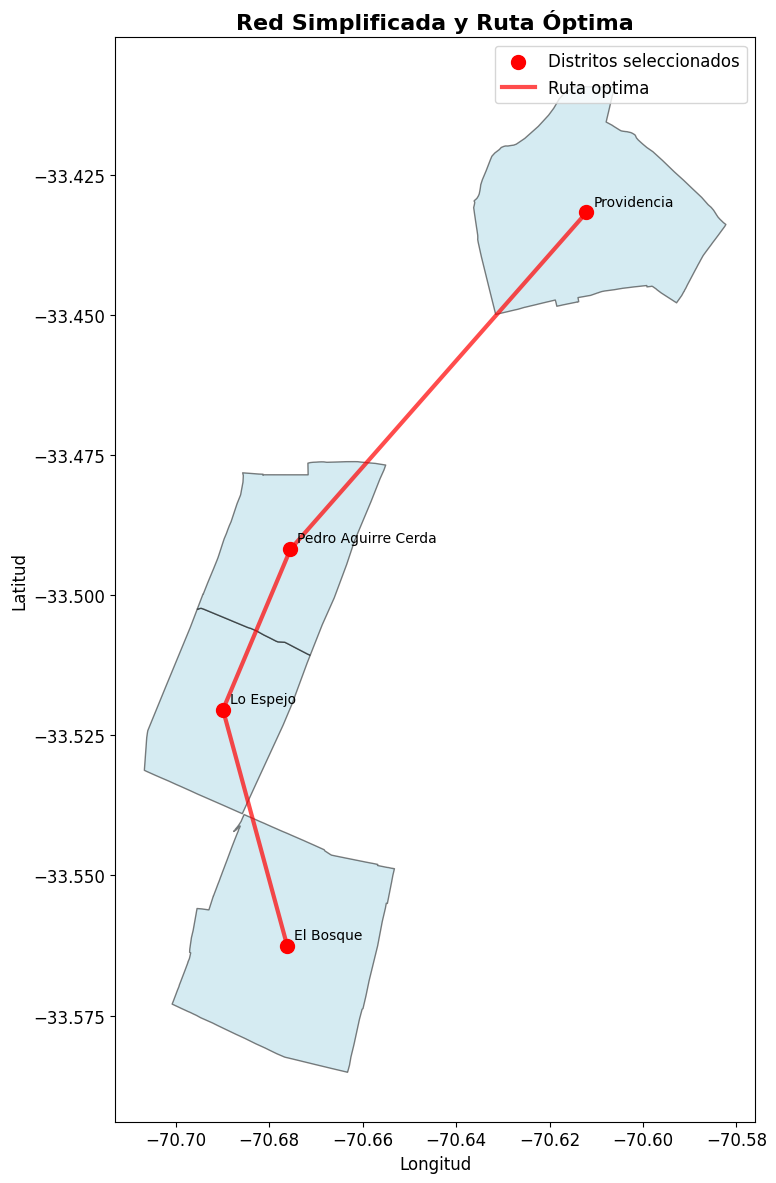

Distritos analizados: 4
Ruta optima: Providencia -> Pedro Aguirre Cerda -> Lo Espejo -> El Bosque
Distancia total: 18193.15 metros (18.19 km)
Distancia promedio entre distritos: 4548.29 metros


In [39]:
# Visualizamos la red simplificada y ruta optima

# Creamos la figura
fig, ax = plt.subplots(figsize=(15, 12))

# Graficamos los distritos seleccionados
distritos_gdf.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='black')

# Marcamos los centroides de los distritos
ax.scatter(distritos_gdf['centroide_x'], distritos_gdf['centroide_y'], 
          c='red', s=100, marker='o', label='Distritos seleccionados')

# Dibujar la ruta óptima
if mejor_ruta:
    for i in range(len(mejor_ruta) - 1):
        distrito1 = mejor_ruta[i]
        distrito2 = mejor_ruta[i + 1]
        
        coordenada_1 = (distritos_gdf[distritos_gdf['Comuna'] == distrito1]['centroide_x'].iloc[0],
                 distritos_gdf[distritos_gdf['Comuna'] == distrito1]['centroide_y'].iloc[0])
        coordenada_2 = (distritos_gdf[distritos_gdf['Comuna'] == distrito2]['centroide_x'].iloc[0],
                 distritos_gdf[distritos_gdf['Comuna'] == distrito2]['centroide_y'].iloc[0])
        
        ax.plot([coordenada_1[0], coordenada_2[0]], [coordenada_1[1], coordenada_2[1]], 
               'r-', linewidth=3, alpha=0.7, label='Ruta optima' if i == 0 else "")

# Agregamos etiquetas
for index, fila in distritos_gdf.iterrows():
    ax.annotate(fila['Comuna'], (fila['centroide_x'], fila['centroide_y']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# Configurar gráfico
ax.set_title('Red Simplificada y Ruta Óptima', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Distritos analizados: {len(distritos_gdf)}")
print(f"Ruta optima: {' -> '.join(map(str, mejor_ruta))}")
print(f"Distancia total: {round(menor_costo, 2)} metros ({round(menor_costo/1000, 2)} km)")
print(f"Distancia promedio entre distritos: {round(menor_costo/len(mejor_ruta), 2)} metros")

## Ejercicio 4: Análisis de Zonas Críticas y Centros de Intervención

In [40]:
# Descarga de red vial de Santiago
G_santiago = ox.graph_from_place('Santiago, Chile', network_type='drive')

print(f"Red vial de Santiago: {G_santiago.number_of_nodes()} nodos, {G_santiago.number_of_edges()} aristas")

Red vial de Santiago: 2421 nodos, 4530 aristas


In [41]:
# Calculo de métricas de centralidad para identificar zonas críticas
centralidad_degree = nx.degree_centrality(G_santiago)
centralidad_betweenness = nx.betweenness_centrality(G_santiago, weight='length')
centralidad_closeness = nx.closeness_centrality(G_santiago, distance='length')

# Creamos un DataFrame con todas las métricas para poder compararlas.
centralidad_santiago_df = pd.DataFrame({
    'degree': centralidad_degree,
    'betweenness': centralidad_betweenness,
    'closeness': centralidad_closeness
})

# Identificamos los nodos críticos según el percentil 95. 
percentil_95_degree = centralidad_santiago_df['degree'].quantile(0.95)
percentil_95_betweenness = centralidad_santiago_df['betweenness'].quantile(0.95)
percentil_95_closeness = centralidad_santiago_df['closeness'].quantile(0.95)

nodos_criticos_degree = centralidad_santiago_df[centralidad_santiago_df['degree'] >= percentil_95_degree].index.tolist()
nodos_criticos_betweenness = centralidad_santiago_df[centralidad_santiago_df['betweenness'] >= percentil_95_betweenness].index.tolist()
nodos_criticos_closeness = centralidad_santiago_df[centralidad_santiago_df['closeness'] >= percentil_95_closeness].index.tolist()

print(f"Nodos críticos por grado: {len(nodos_criticos_degree)}")
print(f"Nodos críticos por intermediación: {len(nodos_criticos_betweenness)}")
print(f"Nodos críticos por cercanía: {len(nodos_criticos_closeness)}")

Nodos críticos por grado: 194
Nodos críticos por intermediación: 122
Nodos críticos por cercanía: 122


Las métricasd a usar serán: Betweenness y Closeness. El motivo por el cual  elegimos estas metricas es debido a que, por un lado, Betweenness identifica nodos estratégicos para la conectividad vial, mientras que closeness optimiza la accesibilidad promedio a todos los puntos de la red, lo cual, se puede considerar como una combinación ideal para centros de emergencia.

In [42]:
# Seleccionamos las 3 ubicaciones de centros de intervención en base a las metricas de centralidad: betweenness y closeness.

# Calculamos el score combinado
centralidad_santiago_df['score'] = (
    centralidad_santiago_df['betweenness'] + 
    centralidad_santiago_df['closeness']
)

# Seleccionamos aquellos que tengan el puntaje mayor, especificamente el 20% de los que tengan el puntaje mayor.
candidatos = centralidad_santiago_df.nlargest(int(len(centralidad_santiago_df) * 0.2), 'score')

In [43]:
# Creamos esta función para calcular distancia entre nodos
def distancia_nodos(nodo1, nodo2):
    x1, y1 = G_santiago.nodes[nodo1]['x'], G_santiago.nodes[nodo1]['y']
    x2, y2 = G_santiago.nodes[nodo2]['x'], G_santiago.nodes[nodo2]['y']
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) * 111000  # Convertir a metros

In [44]:
# buscamos las ubicaciones que maximizan la cobertura espacial
ubicaciones_centros = []
candidatos = candidatos.index.tolist()

primer_centro = candidatos[0]
ubicaciones_centros.append(primer_centro)
candidatos.remove(primer_centro)

# Seleccionamos los centros considerando distancia mínima
distancia_minima = 2000  # Definimos 2km como la distancia mínima entre centros

while len(ubicaciones_centros) < 3 and candidatos:
    mejor_candidato = None
    mejor_score = -1
    
    for candidato in candidatos:
        score_candidato = centralidad_santiago_df.loc[candidato, 'score']
        if score_candidato > mejor_score:
            mejor_score = score_candidato
            mejor_candidato = candidato
    
    ubicaciones_centros.append(mejor_candidato)
    candidatos.remove(mejor_candidato)


In [45]:
print("Ubicaciones posibles para centros de intervención:")
for i, ubicacion in enumerate(ubicaciones_centros, start=1):
    x = G_santiago.nodes[ubicacion]['x']
    y = G_santiago.nodes[ubicacion]['y']
    score = centralidad_santiago_df.loc[ubicacion, 'score']
    print(f"Centro {i}: Nodo {ubicacion} en ({round(x, 6)}, {round(y, 6)}) con Score: {round(score, 4)}")

# Calculamos las distancias entre centros
print("Distancias entre centros:")
for i in range(len(ubicaciones_centros)):
    for j in range(i+1, len(ubicaciones_centros)):
        dist = distancia_nodos(ubicaciones_centros[i], ubicaciones_centros[j])
        print(f"Centro {i+1} a Centro {j+1}: {round(dist, 0)} metros")

Ubicaciones posibles para centros de intervención:
Centro 1: Nodo 4765531800 en (-70.664801, -33.447398) con Score: 0.0948
Centro 2: Nodo 369950565 en (-70.660595, -33.446487) con Score: 0.0882
Centro 3: Nodo 253348601 en (-70.656914, -33.453171) con Score: 0.0875
Distancias entre centros:
Centro 1 a Centro 2: 478.0 metros
Centro 1 a Centro 3: 1085.0 metros
Centro 2 a Centro 3: 847.0 metros


Las excentricidades son una métrica que nos permite medir la distancia máxima desde un nodo a cualquier otro nodo en la red. Son importantes para este caso porque nos dicen a que distancia maxima pueden llegar a cubrir los centros de atención. 


In [46]:
# Calculamos las excentricidades de los centros.

excentricidades = {}
coberturas = {}

for i, ubicacion in enumerate(ubicaciones_centros):
    
    # Intentamos primero calcular excentricidad real, que es la distancia máxima desde un nodo a cualquier otro nodo en la red que descargamos
    try: 
        excentricidad = nx.eccentricity(G_santiago, ubicacion, weight='length')
        excentricidades[f'Centro_{i+1}'] = excentricidad
        # En caso de que no se pueda calcular, usamos una estimación conservadora.
    except Exception as e:
        
        # En lugar de estimar excentricidad, usemos una métrica alternativa, que es la de calcular la 
        # distancia promedio a todos los nodos de la red
        distancias_totales = []
        for otro_nodo in G_santiago.nodes():
            if otro_nodo != ubicacion:
                try:
                    distancia = nx.shortest_path_length(G_santiago, ubicacion, otro_nodo, weight='length')
                    distancias_totales.append(distancia)
                except:
                    continue
        
        if distancias_totales:
            distancia_promedio = np.mean(distancias_totales)
            distancia_maxima = np.max(distancias_totales)
            excentricidades[f'Centro_{i+1}'] = distancia_maxima
        else:
            # Si no podemos calcular distancias, usar una estimación conservadora, que sería una distancia máxima de unos 15 kilometros
            excentricidades[f'Centro_{i+1}'] = 15000

# Identificamos el mejor centro (menor excentricidad = mejor accesibilidad)

mejor_centro_id = min(excentricidades, key=excentricidades.get)
mejor_excentricidad = excentricidades[mejor_centro_id]


In [47]:
# Obtenemos la cobertura de puntos críticos de accidentes

# Función para encontrar el centro más cercano a un punto de accidente
def centro_mas_cercano(punto_accidente, centros):
    min_distancia = float('inf')
    centro_cercano = None
    
    for centro in centros:
        x_centro = G_santiago.nodes[centro]['x']
        y_centro = G_santiago.nodes[centro]['y']
        
        # Calcular distancia euclidiana
        distancia = np.sqrt((punto_accidente.x - x_centro)**2 + (punto_accidente.y - y_centro)**2) * 111000
        
        if distancia < min_distancia:
            min_distancia = distancia
            centro_cercano = centro
    
    return centro_cercano, min_distancia

# Cobertura de puntos críticos

cobertura_por_centro = {f"Centro_{i+1}": 0 for i in range(len(ubicaciones_centros))}
distancias_accidentes = []

for idx, punto in puntos_criticos.iterrows():
    centro_cercano, distancia = centro_mas_cercano(punto.geometry, ubicaciones_centros)
    centro_idx = ubicaciones_centros.index(centro_cercano)
    cobertura_por_centro[f"Centro_{centro_idx+1}"] += 1
    distancias_accidentes.append(distancia)

print("Puntos críticos cubiertos por cada centro:")
for centro, cantidad in cobertura_por_centro.items():
    print(f"  {centro}: {cantidad} puntos críticos")



Puntos críticos cubiertos por cada centro:
  Centro_1: 246 puntos críticos
  Centro_2: 111 puntos críticos
  Centro_3: 445 puntos críticos


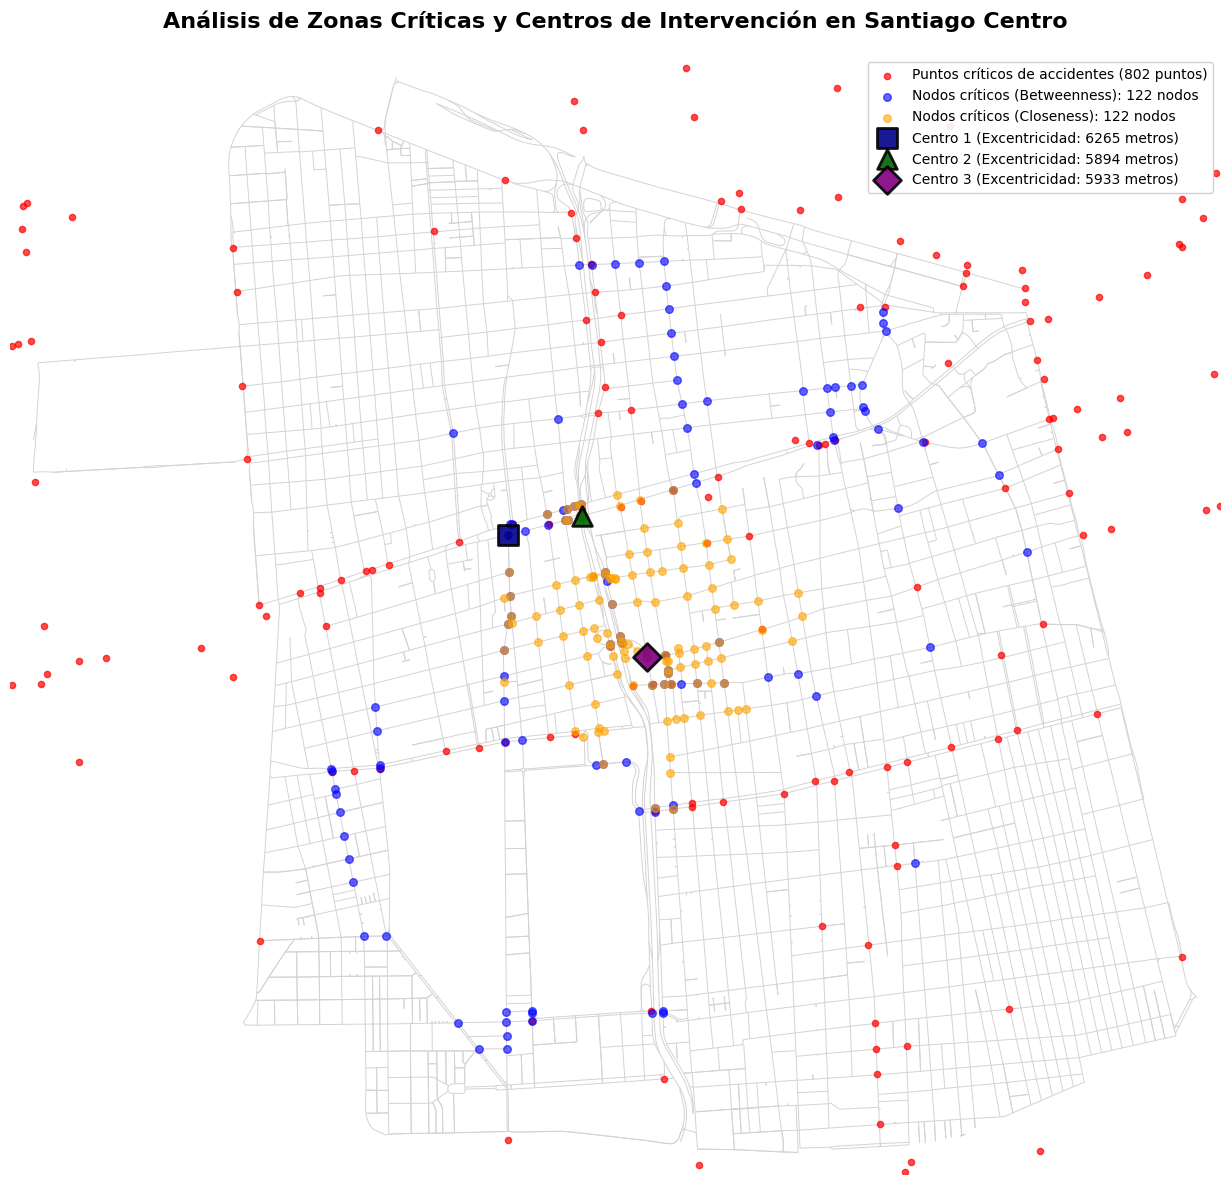

In [48]:
# Visualizamos el panorama.

# Configurar la figura
fig, ax = plt.subplots(figsize=(15, 12))

ox.plot_graph(G_santiago, ax=ax, node_size=0, edge_color='lightgray', edge_linewidth=0.7, 
              bgcolor='white', show=False, close=False)

# Graficamos los puntos críticos de accidentes.

puntos_criticos.plot(ax=ax, color='red', markersize=20, alpha=0.7, 
                     label=f'Puntos críticos de accidentes ({len(puntos_criticos)} puntos)')

# Graficamos los nodos críticos por betweenness.
nodos_betweenness_coordenadas = []
for nodo in nodos_criticos_betweenness:  
    if nodo in G_santiago.nodes:
        x = G_santiago.nodes[nodo]['x']
        y = G_santiago.nodes[nodo]['y']
        nodos_betweenness_coordenadas.append((x, y))

# Graficamos los puntos de betweenness 
x_coords_betweenness, y_coords_betweenness = [], []
for p in nodos_betweenness_coordenadas:
    x_coords_betweenness.append(p[0])
    y_coords_betweenness.append(p[1])
ax.scatter(x_coords_betweenness, y_coords_betweenness, c='blue', s=30, alpha=0.6,
            label=f'Nodos críticos (Betweenness): {len(nodos_betweenness_coordenadas)} nodos')

# Graficamos los nodos críticos por closeness.
nodos_closeness_coordenadas = []
for nodo in nodos_criticos_closeness: 
    if nodo in G_santiago.nodes:
        x = G_santiago.nodes[nodo]['x']
        y = G_santiago.nodes[nodo]['y']
        nodos_closeness_coordenadas.append((x, y))  

if nodos_closeness_coordenadas:
    x_coords_closeness, y_coords_closeness = [], []
    for p in nodos_closeness_coordenadas:
        x_coords_closeness.append(p[0])
        y_coords_closeness.append(p[1])
    ax.scatter(x_coords_closeness, y_coords_closeness, c='orange', s=30, alpha=0.6,
                label=f'Nodos críticos (Closeness): {len(nodos_closeness_coordenadas)} nodos')

# Graficamos los centros propuestos.

colores_centros = ['darkblue', 'darkgreen', 'purple']
marcadores_centros = ['s', '^', 'D']  # Cuadrado, triángulo, diamante, dados por el chat, para que se vean mejor los centros en el mapa.

for i, ubicacion in enumerate(ubicaciones_centros):
    x = G_santiago.nodes[ubicacion]['x']
    y = G_santiago.nodes[ubicacion]['y']
    
    excentricidad = excentricidades.get(f"Centro_{i+1}", 0)
    texto_excentricidad = f"{int(excentricidad)} metros"
    
    ax.scatter(x, y, c=colores_centros[i], s=200, marker=marcadores_centros[i], 
               edgecolor='black', linewidth=2, alpha=0.9, zorder=5,
               label=f'Centro {i+1} (Excentricidad: {texto_excentricidad})')

ax.set_title('Análisis de Zonas Críticas y Centros de Intervención en Santiago Centro', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
